Open questions
 - is there a problem with the gradient being larger in LUNA relative NLM
 - why do confidence bands look wonky for larger max iterations
 - 

In [1]:
# external libraries
!pip install autograd
from autograd import numpy as np
from autograd import grad
from autograd.misc.optimizers import adam, sgd
from autograd import scipy as sp
import autograd.numpy.random as npr

import numpy
import math
import matplotlib.pyplot as plt
import pandas as pd
import sys
import time


# our model libraries
from feed_forward import Feedforward
from nlm import NLM
from luna import LUNA

# our support libraries
import utils
import bayes_helpers as bh
from config import *

You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.


### The Cubic Gap Dataset

$$y = x^3 + \epsilon$$

$$\epsilon \sim N(0, 3^2)$$

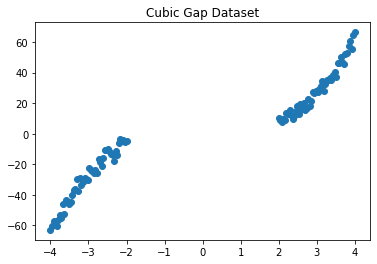

In [29]:
# training data
x_train, y_train, x_test = utils.generate_data(training_seed)

# for model evaluation: computing log likelihood
x_valid, y_valid, x_test_not_used = utils.generate_data(valid_seed)


plt.scatter(x_train, y_train)
plt.title('Cubic Gap Dataset')
plt.show()

Note: `real_max_iteration`, `prior_variance`, `y_noise_variance`, `nlm_architecture`, `random_seed`, `optparams` are defined in config.py

In [24]:
### Compare NLM to Vanilla Neural Network
# embarassingly, max loves plain vanilla ice cream


# Ensure 3500 iterations are used for optimization
opt_params['max_iteration'] = real_max_iteration



####################################################
### Vanilla NN Demo
nn = Feedforward(nlm_architecture, random=random_seed)

t0 = time.time()
nn.fit(x_train, y_train, opt_params)
nn_time = np.round(time.time() - t0, 3)
nn_mse = nn.objective_trace.min()

print(f"Neural Network\n {nn_time} Seconds, Log Likelihood {mse}")

#predict on the test x-values
nn_y_test_pred = nn.forward(nn.weights, x_test)
#####################################################





#####################################################
### NLM Demo

test_nlm = NLM(prior_variance,
               y_noise_variance,
               regularization_param_nlm, 
               nlm_architecture, 
               random_state = random_seed)


t0 = time.time()
test_nlm.train(x_train,y_train, opt_params)
nlm_time = np.round(time.time() - t0, 3)
nlm_mse = test_nlm.ff.objective_trace.min()

print(f"Neural Linear Model\n{nlm_time} Seconds, {nlm_mse} MSE")
#####################################################


 Iteration 3400 lower bound 1277.4601435205495; gradient mag: 1089.6413781579747Neural Network
 53.175 Seconds, Log Likelihood 873.3255312571937
 Iteration 3400 lower bound 290.42456748879; gradient mag: 8.283155210893563
Done Training
Neural Linear Model
54.146 Seconds, 287.7402774662611 MSE


In [46]:
######## Calculate posterior predictive interval for the NLM
predictives, predictive_samples = test_nlm.predict(x_test,prior = False)

# Compute the 97.5 th percentile of the posterior predictive predictions
pp_upper = np.percentile(predictive_samples, 97.5, axis=0)

# Compute the 2.5 th percentile of the posterior predictive predictions
pp_lower = np.percentile(predictive_samples, 2.5, axis=0)

# Compute the 50 th percentile of the posterior predictive predictions
pp_mean = np.mean(predictive_samples, axis=0)

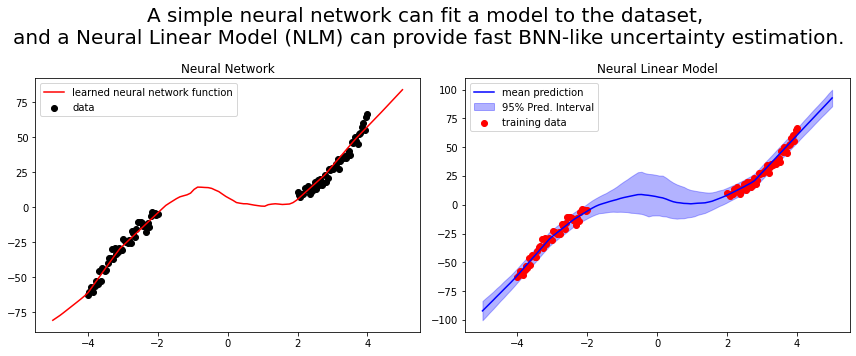

In [47]:
############################################################
fig, ax = plt.subplots(1, 2, figsize = (12, 5))

fig.suptitle('A simple neural network can fit a model to the dataset, \nand a Neural Linear Model (NLM) can provide fast BNN-like uncertainty estimation.', fontsize = 20)

#visualize the function learned by the neural network
ax[0].scatter(x_train.flatten(), y_train.flatten(), color='black', label='data')
ax[0].plot(x_test.flatten(), nn_y_test_pred.flatten(), color='red', label='learned neural network function')
ax[0].legend(loc='best')
ax[0].set_title('Neural Network')


ax[1].plot(x_test.flatten(), pp_mean, color='blue', label = 'mean prediction') # visualize the mean of the posterior predictive
ax[1].fill_between(x_test.flatten(), pp_upper, pp_lower, color='blue', alpha=0.3, label='95% Pred. Interval') # visualize the 95% posterior predictive interval
ax[1].scatter(x_train.flatten(), y_train.flatten(), color='red', label='training data') # visualize the training data
ax[1].legend(loc='best')
ax[1].set_title('Neural Linear Model')
plt.tight_layout()
plt.show()
############################################################

NLMs are unreliable at achieving good uncertainty estimations for gaps, particularly for higher-dimensional data.

The NLM objective function only focuses on improving the model relative to the training data, particular because regularization diminishes model expressiveness which reduces the diversity of the model's learned feature basis.

## Luna

Note: `prior_variance`, `y_noise_variance`, `regularization_param_luna`, `similarity_param`, `luna_architecture`, `random_seed`, `opt_params` are defined in config.py

In [37]:
t0 = time.time()
luna = LUNA(prior_variance, y_noise_variance, regularization_param_luna, similarity_param, luna_architecture, random_seed)
luna.train(x_train, y_train, opt_params)
print(f"Luna\ntime: {np.round(time.time() - t0, 3)} seconds")

 Iteration 3400 lower bound -6041.454945238458; gradient mag: 177.44539800903573
Done Training
Luna
time: 4596.697 seconds


### LUNA provides better uncertainty estimation than an NLM


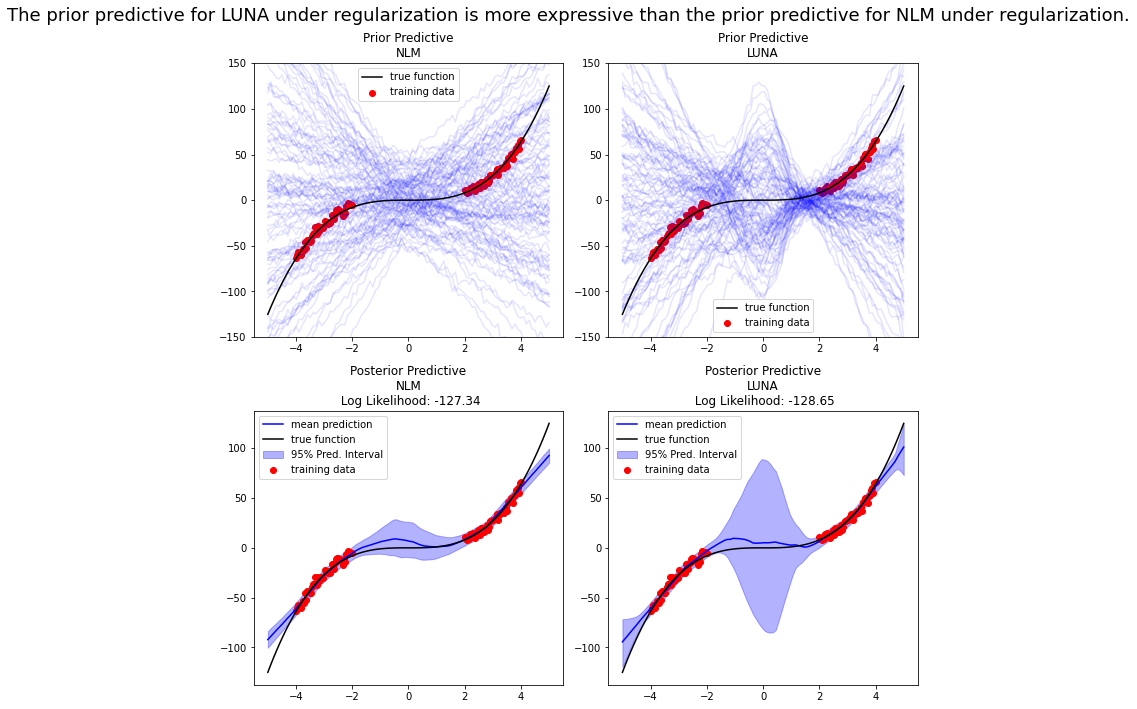

In [60]:
fig,ax = plt.subplots(2,2 ,figsize=(10,10))
fig.suptitle('The prior predictive for LUNA under regularization is more expressive than the prior predictive for NLM under regularization.', fontsize = 18)
names = ['NLM', 'LUNA']
models = [test_nlm, luna]
i = 0
for i in range(2):
    name, model = names[i], models[i]
    prior_predictives, prior_predictive_samples = model.predict(x_test,prior=True)
    posterior_predictives, posterior_predictive_samples = model.predict(x_test,prior=False)
    log_l = model.get_log_l(x_train,y_train,x_valid,y_valid)

    # Compute the 97.5 th percentile of the posterior predictive predictions
    pp_upper = np.percentile(posterior_predictive_samples, 97.5, axis=0)

    # Compute the 2.5 th percentile of the posterior predictive predictions
    pp_lower = np.percentile(posterior_predictive_samples, 2.5, axis=0)

    # Compute the 50 th percentile of the posterior predictive predictions
    pp_mean = np.mean(posterior_predictive_samples, axis=0)

    for j in range(prior_predictive_samples.shape[1]):
        
        ax[0,i].plot(x_test.flatten(), prior_predictive_samples[j,:], alpha = 0.1, color='blue')
    ax[0,i].set_title(f'Prior Predictive\n{name}')
    ax[0,i].scatter(x_train.flatten(), y_train.flatten(), color='red', label='training data') # visualize the training data
    ax[0,i].set_ylim([-150,150])
    ax[0,i].plot(x_test.flatten(), x_test.flatten()**3, color = 'black', label = 'true function')
    ax[0,i].legend(loc = 'best')

    ax[1,i].plot(x_test.flatten(), pp_mean, color='blue', label = 'mean prediction') # visualize the mean of the posterior predictive
    ax[1,i].fill_between(x_test.flatten(), pp_upper, pp_lower, color='blue', alpha=0.3, label='95% Pred. Interval') # visualize the 95% posterior predictive interval
    ax[1,i].scatter(x_train.flatten(), y_train.flatten(), color='red', label='training data') # visualize the training data
    ax[1,i].plot(x_test.flatten(), x_test.flatten()**3, color = 'black', label = 'true function')
    ax[1,i].set_title(f'Posterior Predictive\n{name}\n Log Likelihood: {round(log_l,2)}')
    ax[1,i].legend(loc = 'best')
plt.tight_layout()
plt.show()

### Code: Demonstration on at least one instance the failure mode of the model/algorithm/solution, with an explanation for why failure occurred (is the dataset too large? Did you choose a bad hyper parameter?). The point of this is to point out edge cases to the user.

- show posterior predictive for 1000, 2000, ..., 10000 iterations

- different gap datasets require diff hyperparameters (max thinks)


In [61]:
lunas = []
for i in range(1,11):
    t0 = time.time()
    luna = LUNA(prior_variance, y_noise_variance, regularization_param_luna, similarity_param, luna_architecture, random_seed)
    opt_params['max_iteration'] = i*1000
    luna.train(x_train, y_train, opt_params)
    print(f"Luna {i*1000} iterations\ntime: {np.round(time.time() - t0, 3)} seconds")
    lunas.append(luna)

 Iteration 300 lower bound 13842.758635712666; gradient mag: 9742.526355515909

 Iteration 400 lower bound 7142.713153189557; gradient mag: 4907.836881710712

 Iteration 900 lower bound 1774.978277469766; gradient mag: 1187.6106820452603
Done Training
Luna 1000 iterations
time: 1292.782 seconds
 Iteration 1900 lower bound -2872.102887435425; gradient mag: 218.08965681251738
Done Training
Luna 2000 iterations
time: 2597.223 seconds
 Iteration 2700 lower bound -3889.3130263794214; gradient mag: 203.4695152082072

KeyboardInterrupt: 